In [1]:
def Run_MNIST_Exp(Num_Epochs):
    %matplotlib notebook
    import keras as keras
    from keras.models import Sequential
    from keras.layers import LSTM, Dense,BatchNormalization,Dropout,Flatten, Conv1D, Conv2D,MaxPool2D
    from keras.losses import binary_crossentropy, categorical_crossentropy
    from keras.metrics import categorical_accuracy
    from keras import regularizers,optimizers
    from keras.regularizers import l2
    import numpy as np
    import scipy.io
    import matplotlib.pyplot as plt
    import gzip
    from keras.layers.core import Lambda
    from scipy.integrate import trapz
    import seaborn as sns

    from keras.layers.core import Lambda
    from keras import backend as K    


    def mini_batches(InputSample,BatchSize):
        Index = np.array(range(InputSample.shape[0]),dtype=int)
        NumBatches = np.int(InputSample.shape[0]/BatchSize)
        Removed = np.array([],dtype=int)

        BatchInd =[]
        for BatchLoop in range(NumBatches):
            RemainIndex = np.delete(Index,Removed)
            SampleInd = np.random.choice(RemainIndex,size=BatchSize,replace=False)
            Removed = np.append(Removed,SampleInd,axis=0)

            BatchInd.append(SampleInd)
        RemainIndex = np.delete(Index,Removed)
        BatchInd.append(RemainIndex)

        return BatchInd,NumBatches

    def Get_Feats_and_Targets(filename):
        import numpy as np

        def line_to_Feats(line):
            line = line.split(' ')
            Feats = np.asarray(line[0:1024])
            Target = np.zeros([3])
            Target[int(line[1024])] = 1
            return Feats,Target

        f = open(filename, 'r')
        lines = f.readlines()
        Features = []
        Targets = []
        for i in range(len(lines)-1):
            line = lines[i+1]
            Feats,Tgts = line_to_Feats(line)
            Features.append(Feats)
            Targets.append(Tgts)

        return np.asarray(Features,dtype = 'float64'), np.asarray(Targets,dtype = 'int')

    
    ConvFlag = 0
    
    FullInputs = scipy.io.loadmat('MNIST_TrainInputs.mat')
    FullInputs = FullInputs['images']

    FullTargets = scipy.io.loadmat('MNIST_TrainTargets.mat')
    FullTargets = FullTargets['targets']

    Validation_Cutoff = 0.75

    Validation_Cutoff = np.int(Validation_Cutoff*FullInputs.shape[0])

    ValInputs = FullInputs[Validation_Cutoff:,:]
    ValTargets = FullTargets[Validation_Cutoff:,:]

    TrainInputs = FullInputs[0:Validation_Cutoff,:]
    TrainTargets = FullTargets[0:Validation_Cutoff,:]
    
    if ConvFlag == 1:
        TrainInputs = TrainInputs.reshape([TrainInputs.shape[0],28,28,1])
        TrainInputs = np.swapaxes(TrainInputs,1,2)

        ValInputs = ValInputs.reshape([ValInputs.shape[0],28,28,1])
        ValInputs = np.swapaxes(ValInputs,1,2)
        
        data_dim2 = TrainInputs.shape[2]

    data_dim = TrainInputs.shape[1]
    NumSamples = TrainInputs.shape[0]
    Num_Targets = TrainTargets.shape[-1]

    index = np.linspace(0,NumSamples,NumSamples,endpoint=False,dtype=int)

    reg_coeff = 0.001

    def Gen_Model(reg_coeff):
        model = Sequential()
        model.add(Dense(100,activation='relu',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
        model.add(Dropout(0.25))
        model.add(Dense(100,activation='relu',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
        model.add(Dropout(0.25))
        model.add(Dense(100,activation='relu',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
        model.add(Dropout(0.25))
        model.add(Dense(Num_Targets,activation = 'softmax',kernel_regularizer=l2(reg_coeff),input_shape =(data_dim,)))
        optim = optimizers.adam(lr=0.0001)
        model.compile(loss='categorical_crossentropy',optimizer=optim,metrics=['categorical_accuracy'])
        return model
        
#     def Gen_Model(reg_coeff):
#         model = Sequential()
#         model.add(Conv2D(100,5,activation='relu',input_shape =(data_dim,data_dim2,1)))
#         model.add(MaxPool2D())
#         model.add(Conv2D(100,5,activation='relu'))
#         model.add(MaxPool2D())
#         model.add(Flatten())
#         model.add(Dense(100,activation='relu',kernel_regularizer=l2(reg_coeff)))
#         model.add(Dense(Num_Targets,activation = 'softmax',kernel_regularizer=l2(reg_coeff),input_shape =(data_dim,)))
#         optim = optimizers.sgd(lr=0.001)
#         model.compile(loss='categorical_crossentropy',optimizer=optim,metrics=['categorical_accuracy'])
#         return model

    VarTempModel = Gen_Model(reg_coeff)
    UniTaskModel = Gen_Model(reg_coeff)
    PropTaskModel = Gen_Model(reg_coeff)
    ConstTempModel = Gen_Model(reg_coeff)
    Uni_model = Gen_Model(reg_coeff)
    
    VarTempModel.set_weights(Uni_model.get_weights())
    UniTaskModel.set_weights(Uni_model.get_weights())
    PropTaskModel.set_weights(Uni_model.get_weights())
    ConstTempModel.set_weights(Uni_model.get_weights())
    
    def acquisition_function_BALD_test(model,samples,Num_Targets,temperature=1,Target_Ratio = 5):
        nb_MC_samples = 30
        MC_samples = np.zeros([nb_MC_samples,samples.shape[0],Num_Targets])
        learning_phase = True 
        for i in range(nb_MC_samples):
            MC_samples[i,:,:] = model.predict(samples)

        expected_entropy = - np.mean(np.sum(MC_samples * np.log(MC_samples + 1e-10), axis=-1), axis=0)  # [batch size]
        expected_p = np.mean(MC_samples, axis=0)
        entropy_expected_p = - np.sum(expected_p * np.log(expected_p + 1e-10), axis=-1)  # [batch size]
        BALD_acq = entropy_expected_p - expected_entropy

        Exp_BALD = np.exp(BALD_acq/temperature)
        Sampling_Prob = Exp_BALD/np.sum(Exp_BALD).astype(float)

        Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
        Target_Ratio = Target_Ratio
        if Max_Prob_Ratio < Target_Ratio:
            while Max_Prob_Ratio <Target_Ratio:
                temperature = temperature*0.99
                Exp_BALD = np.exp(BALD_acq/temperature)
                StoreSampling_Prob = Sampling_Prob.copy()
                Sampling_Prob = Exp_BALD/np.sum(Exp_BALD).astype(float)
                Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
                if np.isnan(Max_Prob_Ratio):
                    Sampling_Prob = StoreSampling_Prob.copy()
        else:
            while Max_Prob_Ratio > Target_Ratio:
                temperature = temperature*1.01
                Exp_BALD = np.exp(BALD_acq/temperature)
                StoreSampling_Prob = Sampling_Prob.copy()
                Sampling_Prob = Exp_BALD/np.sum(Exp_BALD).astype(float)
                Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
                if np.isnan(Max_Prob_Ratio):
                    Sampling_Prob = StoreSampling_Prob.copy()
        return Sampling_Prob
    
    def acquisition_function_dist_to_threshold(model,samples,Num_Targets,temperature=1,Target_Ratio=5):
        Output = model.predict(samples)
        Output -= 1/float(Num_Targets)
        Dist_to_Threshold = np.sum(np.abs(Output),1)
        Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
        Exp_Dist_to_Threshold *= 1
    #     Exp_Dist_to_Threshold = Dist_to_Threshold
        Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
        Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
        Target_Ratio = Target_Ratio
        if Max_Prob_Ratio < Target_Ratio:
            while Max_Prob_Ratio <Target_Ratio:
                temperature = temperature*0.99
                Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
                StoreSampling_Prob = Sampling_Prob.copy()
                Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
                Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
                if np.isnan(Max_Prob_Ratio):
                    Sampling_Prob = StoreSampling_Prob.copy()
        else:
            while Max_Prob_Ratio > Target_Ratio:
                temperature = temperature*1.01
                Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
                StoreSampling_Prob = Sampling_Prob.copy()
                Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
                Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
                if np.isnan(Max_Prob_Ratio):
                    Sampling_Prob = StoreSampling_Prob.copy()
        return Sampling_Prob

    def acquisition_function_dist_to_threshold_const_temp(model,samples,Num_Targets,temperature=1):
        Output = model.predict(samples)
        Output -= 1/float(Num_Targets)
        Dist_to_Threshold = np.sum(np.abs(Output),1)
        Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
        Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
        return Sampling_Prob

    count = 0 
    Num_Epochs = Num_Epochs
    Num_BurnIn = 1
    Batch_Size = 50
    
    NumTasks = 2
    try:
        SwitchPoint = np.int(Num_Epochs/NumTasks)
        print('Switch:')
        print(SwitchPoint)
    except:
        SwitchPoint = 1
    Val_Error = np.zeros([Num_Epochs,5])
    Val_Acc = np.zeros([Num_Epochs,5])

    def Biased_Batch(Inputs,Targets,Batch_Size,Sampling_Probability,Weighting_Flag = 1,NumTasks = 0,CurrentTask=0):
        while True: 
            index = np.linspace(0,Inputs.shape[0],Inputs.shape[0],endpoint=False,dtype=int)
            if NumTasks > 1:
                Cutoff = np.percentile(Sampling_Probability,np.max([100-(CurrentTask*(1/np.float(NumTasks))*100),0]))
                TaskInd = Sampling_Probability >= Cutoff
                DropInd = Sampling_Probability <  Cutoff
                Sampling_Probability[DropInd] = 0
                Sampling_Probability = Sampling_Probability/np.sum(Sampling_Probability,dtype=float)
            Batch = np.random.choice(index,size=Batch_Size,replace=False,p=Sampling_Probability)
            Batch_Inputs = Inputs[Batch,:]
            Batch_Targets = Targets[Batch,:]
            if Weighting_Flag == 1:
                FullWeights = Sampling_Probability**-1
                FullWeights = FullWeights/np.mean(FullWeights)
            elif Weighting_Flag == -1:
                FullWeights = Sampling_Probability/np.mean(Sampling_Probability)
            else:
                FullWeights = np.ones(Inputs.shape[0])
            Weights = FullWeights[Batch]
            yield (Batch_Inputs,Batch_Targets,Weights)
        
    def Biased_Batch_Uni(Inputs,Targets,Batch_Size,Sampling_Probability,Weighting_Flag = 1,NumTasks = 0,CurrentTask=0):
        while True: 
            index = np.linspace(0,Inputs.shape[0],Inputs.shape[0],endpoint=False,dtype=int)
            if NumTasks > 1:
                Cutoff = np.percentile(Sampling_Probability,np.max([100-(CurrentTask*(1/np.float(NumTasks))*100),0]))
                TaskInd = Sampling_Probability >= Cutoff
                DropInd = Sampling_Probability <  Cutoff
                Sampling_Probability[TaskInd] = 1
                Sampling_Probability[DropInd] = 0
                Sampling_Probability = Sampling_Probability/np.sum(Sampling_Probability,dtype=float)
            Batch = np.random.choice(index,size=Batch_Size,replace=False,p=Sampling_Probability)
            Batch_Inputs = Inputs[Batch,:]
            Batch_Targets = Targets[Batch,:]
            if Weighting_Flag == 1:
                FullWeights = Sampling_Probability**-1
                FullWeights = FullWeights/np.mean(FullWeights)
            elif Weighting_Flag == -1:
                FullWeights = Sampling_Probability/np.mean(Sampling_Probability)
            else:
                FullWeights = np.ones(Inputs.shape[0])
            Weights = FullWeights[Batch]
            yield (Batch_Inputs,Batch_Targets,Weights)
            
    fig = plt.figure(figsize = [4,4])
    ax = fig.add_subplot(111)
    plt.ion()
    fig.show()
    fig.canvas.draw()

    fig2 = plt.figure(figsize = [4,4])
    ax2 = fig2.add_subplot(111)
    plt.ion()
    fig2.show()
    fig2.canvas.draw()


    for EpochLoop in  range(Num_Epochs):
        if count < Num_BurnIn:
            Uni_model.fit(TrainInputs,TrainTargets,batch_size = Batch_Size,epochs=1,verbose=1)
            Error = Uni_model.test_on_batch(ValInputs,ValTargets)
            Val_Error[count,:] = Error[0]
            Val_Acc[count,:] = Error[1]
            
            VarTempModel.set_weights(Uni_model.get_weights())
            UniTaskModel.set_weights(Uni_model.get_weights())
            PropTaskModel.set_weights(Uni_model.get_weights())
            ConstTempModel.set_weights(Uni_model.get_weights())
            
        else:
            
            VarTempModel_Probability = acquisition_function_dist_to_threshold(VarTempModel,TrainInputs,Num_Targets,1,10)
            VarTempModel_Probability/= VarTempModel_Probability.sum().astype(float)
            
            UniTaskModel_Probability = acquisition_function_dist_to_threshold_const_temp(UniTaskModel,TrainInputs,Num_Targets,1)
            UniTaskModel_Probability/= UniTaskModel_Probability.sum().astype(float)
            
            PropTaskModel_Probability = acquisition_function_dist_to_threshold(PropTaskModel,TrainInputs,Num_Targets,1,10)
            PropTaskModel_Probability/= PropTaskModel_Probability.sum().astype(float)
            
#             ConstTempModel_Probability = acquisition_function_dist_to_threshold_const_temp(ConstTempModel,TrainInputs,Num_Targets,0.5)
#             ConstTempModel_Probability/= ConstTempModel_Probability.sum().astype(float)
            
            VarTempModel.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,VarTempModel_Probability,0,0,np.int((count-Num_BurnIn)/SwitchPoint)+1),
                                       steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)
            
            Phase = np.int((count-Num_BurnIn)/SwitchPoint)+1
            
            PhaseScale = np.int(NumTasks/Phase)
            
            UniTaskModel.fit_generator(Biased_Batch_Uni(TrainInputs,TrainTargets,Batch_Size,UniTaskModel_Probability,0,NumTasks,np.int((count-Num_BurnIn)/SwitchPoint)+1),  
                                       steps_per_epoch=np.int(PhaseScale*(NumSamples/Batch_Size)),verbose=0)
            
            PropTaskModel.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,PropTaskModel_Probability,0,NumTasks,np.int((count-Num_BurnIn)/SwitchPoint)+1),
                                       steps_per_epoch=np.int(PhaseScale*(NumSamples/Batch_Size)),verbose=0)
            
#             ConstTempModel.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,ConstTempModel_Probability,0,0,np.int((count-Num_BurnIn)/SwitchPoint)+1),
#                                        steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)

            Uni_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,1/np.float(NumSamples)*np.ones(NumSamples),0),
                                    steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=1)

            Error = VarTempModel.test_on_batch(ValInputs,ValTargets)
            Val_Error[count,0] = Error[0]
            Val_Acc[count,0] = Error[1]

            Error = UniTaskModel.test_on_batch(ValInputs,ValTargets)
            Val_Error[count,1] = Error[0]
            Val_Acc[count,1] = Error[1]
            
            Error = PropTaskModel.test_on_batch(ValInputs,ValTargets)
            Val_Error[count,2] = Error[0]
            Val_Acc[count,2] = Error[1]
            
            Error = ConstTempModel.test_on_batch(ValInputs,ValTargets)
            Val_Error[count,3] = Error[0]
            Val_Acc[count,3] = Error[1]

            Error = Uni_model.test_on_batch(ValInputs,ValTargets)
            Val_Error[count,4] = Error[0]
            Val_Acc[count,4] = Error[1]
            
            print(EpochLoop)

        count += 1
        
        ax.clear()
        ax.plot(Val_Error[0:count,0],label='VarTemp')
        ax.plot(Val_Error[0:count,1],label='UniTask')
        ax.plot(Val_Error[0:count,2],label='PropTask')
        ax.plot(Val_Error[0:count,3],label='ConstTemp')
        ax.plot(Val_Error[0:count,4],label='Uniform')
        ax.legend(loc='best')
        fig.canvas.draw()

        ax2.clear()
        ax2.plot(Val_Acc[0:count,0],label='High D2T')
        ax2.plot(Val_Acc[0:count,1],label='UniTask')
        ax2.plot(Val_Acc[0:count,2],label='PropTask')
        ax2.plot(Val_Acc[0:count,3],label='ConstTemp')
        ax2.plot(Val_Acc[0:count,4],label='Uniform')
        fig2.canvas.draw()

    TestInputs = scipy.io.loadmat('MNIST_TestInputs.mat')
    TestInputs = TestInputs['test_images']
    TestTargets = scipy.io.loadmat('MNIST_TestTargets.mat')
    TestTargets = TestTargets['test_targets']
    
#     TestInputs = TestInputs.reshape([TestInputs.shape[0],28,28,1])
#     TestInputs = np.swapaxes(TestInputs,1,2)

    TestError = np.zeros([5,2])
    TestError[0,:] = VarTempModel.test_on_batch(TestInputs,TestTargets)
    TestError[1,:] = UniTaskModel.test_on_batch(TestInputs,TestTargets)
    TestError[2,:] = PropTaskModel.test_on_batch(TestInputs,TestTargets)
    TestError[3,:] = ConstTempModel.test_on_batch(TestInputs,TestTargets)
    TestError[4,:] = Uni_model.test_on_batch(TestInputs,TestTargets)
    
    

    return TestError, Val_Error,Val_Acc

In [2]:
import numpy as np
import datetime
NumRuns = 100
NumEpochs = 50

TestError = np.zeros([5,2,NumRuns])
Val_Error = np.zeros([NumEpochs,5,NumRuns])
Val_Acc = np.zeros([NumEpochs,5,NumRuns])


10
Switch:
25


<IPython.core.display.Javascript object>


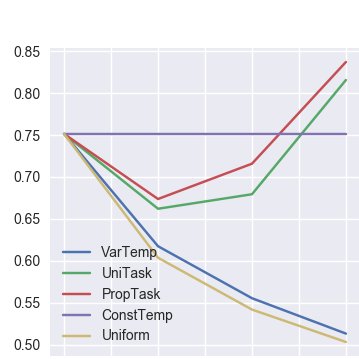

<IPython.core.display.Javascript object>


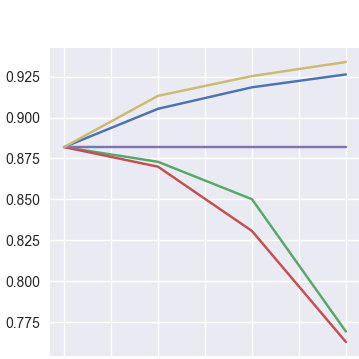

Epoch 1/1
45000/45000 [==============================] - 7s 154us/step - loss: 1.5975 - categorical_accuracy: 0.5861
Epoch 1/1
900/900 [==============================] - 4s 4ms/step - loss: 0.8442 - categorical_accuracy: 0.8378
1
Epoch 1/1
900/900 [==============================] - 4s 4ms/step - loss: 0.7128 - categorical_accuracy: 0.8763
2
Epoch 1/1
900/900 [==============================] - 4s 4ms/step - loss: 0.6359 - categorical_accuracy: 0.8968
3


KeyboardInterrupt: 

In [3]:
from IPython.display import clear_output
for i in range(NumRuns):
    clear_output()
    print(i)
    TestError[:,:,i],Val_Error[:,:,i],Val_Acc[:,:,i] = Run_MNIST_Exp(NumEpochs)
    np.save("Test_Performance_MNIST_Various_CompBootstrap_Final_Easy_2",TestError)
    np.save("Val_Error_MNIST_Various_CompBootstrap_Final_Easy_2",Val_Error)
    np.save("Val_Acc_MNIST_Various_CompBootstrap_Final_Easy_2",Val_Acc)
    


Switch:
25


<IPython.core.display.Javascript object>


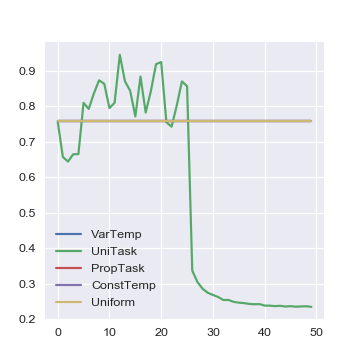

<IPython.core.display.Javascript object>


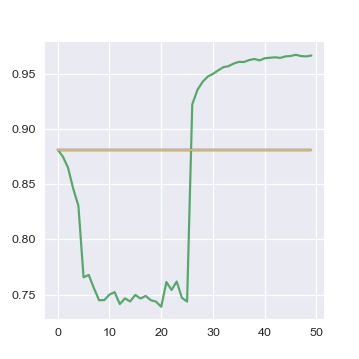

Epoch 1/1
45000/45000 [==============================] - 4s 89us/step - loss: 1.5814 - categorical_accuracy: 0.6000
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [2]:
%matplotlib notebook
import keras as keras
from keras.models import Sequential
from keras.layers import LSTM, Dense,BatchNormalization,Dropout,Flatten, Conv1D, Conv2D,MaxPool2D
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.metrics import categorical_accuracy
from keras import regularizers,optimizers
from keras.regularizers import l2
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import gzip
from keras.layers.core import Lambda
from scipy.integrate import trapz
import seaborn as sns

from keras.layers.core import Lambda
from keras import backend as K    


def mini_batches(InputSample,BatchSize):
    Index = np.array(range(InputSample.shape[0]),dtype=int)
    NumBatches = np.int(InputSample.shape[0]/BatchSize)
    Removed = np.array([],dtype=int)

    BatchInd =[]
    for BatchLoop in range(NumBatches):
        RemainIndex = np.delete(Index,Removed)
        SampleInd = np.random.choice(RemainIndex,size=BatchSize,replace=False)
        Removed = np.append(Removed,SampleInd,axis=0)

        BatchInd.append(SampleInd)
    RemainIndex = np.delete(Index,Removed)
    BatchInd.append(RemainIndex)

    return BatchInd,NumBatches

def Get_Feats_and_Targets(filename):
    import numpy as np

    def line_to_Feats(line):
        line = line.split(' ')
        Feats = np.asarray(line[0:1024])
        Target = np.zeros([3])
        Target[int(line[1024])] = 1
        return Feats,Target

    f = open(filename, 'r')
    lines = f.readlines()
    Features = []
    Targets = []
    for i in range(len(lines)-1):
        line = lines[i+1]
        Feats,Tgts = line_to_Feats(line)
        Features.append(Feats)
        Targets.append(Tgts)

    return np.asarray(Features,dtype = 'float64'), np.asarray(Targets,dtype = 'int')


ConvFlag = 0

FullInputs = scipy.io.loadmat('MNIST_TrainInputs.mat')
FullInputs = FullInputs['images']

FullTargets = scipy.io.loadmat('MNIST_TrainTargets.mat')
FullTargets = FullTargets['targets']

Validation_Cutoff = 0.75

Validation_Cutoff = np.int(Validation_Cutoff*FullInputs.shape[0])

ValInputs = FullInputs[Validation_Cutoff:,:]
ValTargets = FullTargets[Validation_Cutoff:,:]

TrainInputs = FullInputs[0:Validation_Cutoff,:]
TrainTargets = FullTargets[0:Validation_Cutoff,:]

if ConvFlag == 1:
    TrainInputs = TrainInputs.reshape([TrainInputs.shape[0],28,28,1])
    TrainInputs = np.swapaxes(TrainInputs,1,2)

    ValInputs = ValInputs.reshape([ValInputs.shape[0],28,28,1])
    ValInputs = np.swapaxes(ValInputs,1,2)

    data_dim2 = TrainInputs.shape[2]

data_dim = TrainInputs.shape[1]
NumSamples = TrainInputs.shape[0]
Num_Targets = TrainTargets.shape[-1]

index = np.linspace(0,NumSamples,NumSamples,endpoint=False,dtype=int)

reg_coeff = 0.001

def Gen_Model(reg_coeff):
    model = Sequential()
    model.add(Dense(100,activation='relu',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
    model.add(Dropout(0.25))
    model.add(Dense(100,activation='relu',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
    model.add(Dropout(0.25))
    model.add(Dense(100,activation='relu',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
    model.add(Dropout(0.25))
    model.add(Dense(Num_Targets,activation = 'softmax',kernel_regularizer=l2(reg_coeff),input_shape =(data_dim,)))
    optim = optimizers.adam(lr=0.0001)
    model.compile(loss='categorical_crossentropy',optimizer=optim,metrics=['categorical_accuracy'])
    return model

#     def Gen_Model(reg_coeff):
#         model = Sequential()
#         model.add(Conv2D(100,5,activation='relu',input_shape =(data_dim,data_dim2,1)))
#         model.add(MaxPool2D())
#         model.add(Conv2D(100,5,activation='relu'))
#         model.add(MaxPool2D())
#         model.add(Flatten())
#         model.add(Dense(100,activation='relu',kernel_regularizer=l2(reg_coeff)))
#         model.add(Dense(Num_Targets,activation = 'softmax',kernel_regularizer=l2(reg_coeff),input_shape =(data_dim,)))
#         optim = optimizers.sgd(lr=0.001)
#         model.compile(loss='categorical_crossentropy',optimizer=optim,metrics=['categorical_accuracy'])
#         return model

VarTempModel = Gen_Model(reg_coeff)
UniTaskModel = Gen_Model(reg_coeff)
PropTaskModel = Gen_Model(reg_coeff)
ConstTempModel = Gen_Model(reg_coeff)
Uni_model = Gen_Model(reg_coeff)

VarTempModel.set_weights(Uni_model.get_weights())
UniTaskModel.set_weights(Uni_model.get_weights())
PropTaskModel.set_weights(Uni_model.get_weights())
ConstTempModel.set_weights(Uni_model.get_weights())

def acquisition_function_BALD_test(model,samples,Num_Targets,temperature=1,Target_Ratio = 5):
    nb_MC_samples = 30
    MC_samples = np.zeros([nb_MC_samples,samples.shape[0],Num_Targets])
    learning_phase = True 
    for i in range(nb_MC_samples):
        MC_samples[i,:,:] = model.predict(samples)

    expected_entropy = - np.mean(np.sum(MC_samples * np.log(MC_samples + 1e-10), axis=-1), axis=0)  # [batch size]
    expected_p = np.mean(MC_samples, axis=0)
    entropy_expected_p = - np.sum(expected_p * np.log(expected_p + 1e-10), axis=-1)  # [batch size]
    BALD_acq = entropy_expected_p - expected_entropy

    Exp_BALD = np.exp(BALD_acq/temperature)
    Sampling_Prob = Exp_BALD/np.sum(Exp_BALD).astype(float)

    Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
    Target_Ratio = Target_Ratio
    if Max_Prob_Ratio < Target_Ratio:
        while Max_Prob_Ratio <Target_Ratio:
            temperature = temperature*0.99
            Exp_BALD = np.exp(BALD_acq/temperature)
            StoreSampling_Prob = Sampling_Prob.copy()
            Sampling_Prob = Exp_BALD/np.sum(Exp_BALD).astype(float)
            Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
            if np.isnan(Max_Prob_Ratio):
                Sampling_Prob = StoreSampling_Prob.copy()
    else:
        while Max_Prob_Ratio > Target_Ratio:
            temperature = temperature*1.01
            Exp_BALD = np.exp(BALD_acq/temperature)
            StoreSampling_Prob = Sampling_Prob.copy()
            Sampling_Prob = Exp_BALD/np.sum(Exp_BALD).astype(float)
            Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
            if np.isnan(Max_Prob_Ratio):
                Sampling_Prob = StoreSampling_Prob.copy()
    return Sampling_Prob

def acquisition_function_dist_to_threshold(model,samples,Num_Targets,temperature=1,Target_Ratio=5):
    Output = model.predict(samples)
    Output -= 1/float(Num_Targets)
    Dist_to_Threshold = np.sum(np.abs(Output),1)
    Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
    Exp_Dist_to_Threshold *= 1
#     Exp_Dist_to_Threshold = Dist_to_Threshold
    Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
    Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
    Target_Ratio = Target_Ratio
    if Max_Prob_Ratio < Target_Ratio:
        while Max_Prob_Ratio <Target_Ratio:
            temperature = temperature*0.99
            Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
            StoreSampling_Prob = Sampling_Prob.copy()
            Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
            Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
            if np.isnan(Max_Prob_Ratio):
                Sampling_Prob = StoreSampling_Prob.copy()
    else:
        while Max_Prob_Ratio > Target_Ratio:
            temperature = temperature*1.01
            Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
            StoreSampling_Prob = Sampling_Prob.copy()
            Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
            Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
            if np.isnan(Max_Prob_Ratio):
                Sampling_Prob = StoreSampling_Prob.copy()
    return Sampling_Prob

def acquisition_function_dist_to_threshold_const_temp(model,samples,Num_Targets,temperature=1):
    Output = model.predict(samples)
    Output -= 1/float(Num_Targets)
    Dist_to_Threshold = np.sum(np.abs(Output),1)
    Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
    Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
    return Sampling_Prob

count = 0 
Num_Epochs = 50
Num_BurnIn = 1
Batch_Size = 50

NumTasks = 2
try:
    SwitchPoint = np.int(Num_Epochs/NumTasks)
    print('Switch:')
    print(SwitchPoint)
except:
    SwitchPoint = 1
Val_Error = np.zeros([Num_Epochs,5])
Val_Acc = np.zeros([Num_Epochs,5])

def Biased_Batch(Inputs,Targets,Batch_Size,Sampling_Probability,Weighting_Flag = 1,NumTasks = 0,CurrentTask=0):
    while True: 
        index = np.linspace(0,Inputs.shape[0],Inputs.shape[0],endpoint=False,dtype=int)
        if NumTasks > 1:
            Cutoff = np.percentile(Sampling_Probability,np.max([100-(CurrentTask*(1/np.float(NumTasks))*100),0]))
            TaskInd = Sampling_Probability >= Cutoff
            DropInd = Sampling_Probability <  Cutoff
            Sampling_Probability[DropInd] = 0
            Sampling_Probability = Sampling_Probability/np.sum(Sampling_Probability,dtype=float)
        Batch = np.random.choice(index,size=Batch_Size,replace=False,p=Sampling_Probability)
        Batch_Inputs = Inputs[Batch,:]
        Batch_Targets = Targets[Batch,:]
        if Weighting_Flag == 1:
            FullWeights = Sampling_Probability**-1
            FullWeights = FullWeights/np.mean(FullWeights)
        elif Weighting_Flag == -1:
            FullWeights = Sampling_Probability/np.mean(Sampling_Probability)
        else:
            FullWeights = np.ones(Inputs.shape[0])
        Weights = FullWeights[Batch]
        yield (Batch_Inputs,Batch_Targets,Weights)

def Biased_Batch_Uni(Inputs,Targets,Batch_Size,Sampling_Probability,Weighting_Flag = 1,NumTasks = 0,CurrentTask=0):
    while True: 
        index = np.linspace(0,Inputs.shape[0],Inputs.shape[0],endpoint=False,dtype=int)
        if NumTasks > 1:
            Cutoff = np.percentile(Sampling_Probability,np.max([100-(CurrentTask*(1/np.float(NumTasks))*100),0]))
            TaskInd = Sampling_Probability >= Cutoff
            DropInd = Sampling_Probability <  Cutoff
            Sampling_Probability[TaskInd] = 1
            Sampling_Probability[DropInd] = 0
            Sampling_Probability = Sampling_Probability/np.sum(Sampling_Probability,dtype=float)
        Batch = np.random.choice(index,size=Batch_Size,replace=False,p=Sampling_Probability)
        Batch_Inputs = Inputs[Batch,:]
        Batch_Targets = Targets[Batch,:]
        if Weighting_Flag == 1:
            FullWeights = Sampling_Probability**-1
            FullWeights = FullWeights/np.mean(FullWeights)
        elif Weighting_Flag == -1:
            FullWeights = Sampling_Probability/np.mean(Sampling_Probability)
        else:
            FullWeights = np.ones(Inputs.shape[0])
        Weights = FullWeights[Batch]
        yield (Batch_Inputs,Batch_Targets,Weights)

fig = plt.figure(figsize = [4,4])
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

fig2 = plt.figure(figsize = [4,4])
ax2 = fig2.add_subplot(111)
plt.ion()
fig2.show()
fig2.canvas.draw()


for EpochLoop in  range(Num_Epochs):
    if count < Num_BurnIn:
        Uni_model.fit(TrainInputs,TrainTargets,batch_size = Batch_Size,epochs=1,verbose=1)
        Error = Uni_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,:] = Error[0]
        Val_Acc[count,:] = Error[1]

        VarTempModel.set_weights(Uni_model.get_weights())
        UniTaskModel.set_weights(Uni_model.get_weights())
        PropTaskModel.set_weights(Uni_model.get_weights())
        ConstTempModel.set_weights(Uni_model.get_weights())

    else:

        VarTempModel_Probability = acquisition_function_dist_to_threshold(UniTaskModel,TrainInputs,Num_Targets,1,10)
        VarTempModel_Probability/= VarTempModel_Probability.sum().astype(float)

        UniTaskModel_Probability = acquisition_function_dist_to_threshold_const_temp(UniTaskModel,TrainInputs,Num_Targets,1)
        UniTaskModel_Probability/= UniTaskModel_Probability.sum().astype(float)

#         PropTaskModel_Probability = acquisition_function_dist_to_threshold(PropTaskModel,TrainInputs,Num_Targets,1,10)
#         PropTaskModel_Probability/= PropTaskModel_Probability.sum().astype(float)

#             ConstTempModel_Probability = acquisition_function_dist_to_threshold_const_temp(ConstTempModel,TrainInputs,Num_Targets,0.5)
#             ConstTempModel_Probability/= ConstTempModel_Probability.sum().astype(float)

#         VarTempModel.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,VarTempModel_Probability,0,0,np.int((count-Num_BurnIn)/SwitchPoint)+1),
#                                    steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)

        Phase = np.int((count-Num_BurnIn)/SwitchPoint)+1

        PhaseScale = np.int(NumTasks/Phase)

        UniTaskModel.fit_generator(Biased_Batch_Uni(TrainInputs,TrainTargets,Batch_Size,UniTaskModel_Probability,0,NumTasks,np.int((count-Num_BurnIn)/SwitchPoint)+1),  
                                   steps_per_epoch=np.int(PhaseScale*(NumSamples/Batch_Size)),verbose=0)

#         PropTaskModel.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,PropTaskModel_Probability,0,NumTasks,np.int((count-Num_BurnIn)/SwitchPoint)+1),
#                                    steps_per_epoch=np.int(PhaseScale*(NumSamples/Batch_Size)),verbose=0)

#             ConstTempModel.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,ConstTempModel_Probability,0,0,np.int((count-Num_BurnIn)/SwitchPoint)+1),
#                                        steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)

#         Uni_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,1/np.float(NumSamples)*np.ones(NumSamples),0),
#                                 steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=1)

        Error = VarTempModel.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,0] = Error[0]
        Val_Acc[count,0] = Error[1]

        Error = UniTaskModel.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,1] = Error[0]
        Val_Acc[count,1] = Error[1]

        Error = PropTaskModel.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,2] = Error[0]
        Val_Acc[count,2] = Error[1]

        Error = ConstTempModel.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,3] = Error[0]
        Val_Acc[count,3] = Error[1]

        Error = Uni_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,4] = Error[0]
        Val_Acc[count,4] = Error[1]

        print(EpochLoop)

    count += 1

    ax.clear()
    ax.plot(Val_Error[0:count,0],label='VarTemp')
    ax.plot(Val_Error[0:count,1],label='UniTask')
    ax.plot(Val_Error[0:count,2],label='PropTask')
    ax.plot(Val_Error[0:count,3],label='ConstTemp')
    ax.plot(Val_Error[0:count,4],label='Uniform')
    ax.legend(loc='best')
    fig.canvas.draw()

    ax2.clear()
    ax2.plot(Val_Acc[0:count,0],label='High D2T')
    ax2.plot(Val_Acc[0:count,1],label='UniTask')
    ax2.plot(Val_Acc[0:count,2],label='PropTask')
    ax2.plot(Val_Acc[0:count,3],label='ConstTemp')
    ax2.plot(Val_Acc[0:count,4],label='Uniform')
    fig2.canvas.draw()

TestInputs = scipy.io.loadmat('MNIST_TestInputs.mat')
TestInputs = TestInputs['test_images']
TestTargets = scipy.io.loadmat('MNIST_TestTargets.mat')
TestTargets = TestTargets['test_targets']

#     TestInputs = TestInputs.reshape([TestInputs.shape[0],28,28,1])
#     TestInputs = np.swapaxes(TestInputs,1,2)

TestError = np.zeros([5,2])
TestError[0,:] = VarTempModel.test_on_batch(TestInputs,TestTargets)
TestError[1,:] = UniTaskModel.test_on_batch(TestInputs,TestTargets)
TestError[2,:] = PropTaskModel.test_on_batch(TestInputs,TestTargets)
TestError[3,:] = ConstTempModel.test_on_batch(TestInputs,TestTargets)
TestError[4,:] = Uni_model.test_on_batch(TestInputs,TestTargets)


In [3]:
VarTempModel_Probability

array([1.6400762e-05, 2.3835866e-05, 2.2967193e-05, ..., 2.3286419e-05,
       2.2648974e-05, 2.3894336e-05], dtype=float32)

In [4]:
VarTempModel_Probability_Sort = np.argsort(VarTempModel_Probability)

In [42]:
TopTenUncertain = VarTempModel_Probability_Sort[8:12]
TopTenMostCertain = VarTempModel_Probability_Sort[-1-8:]

<IPython.core.display.Javascript object>


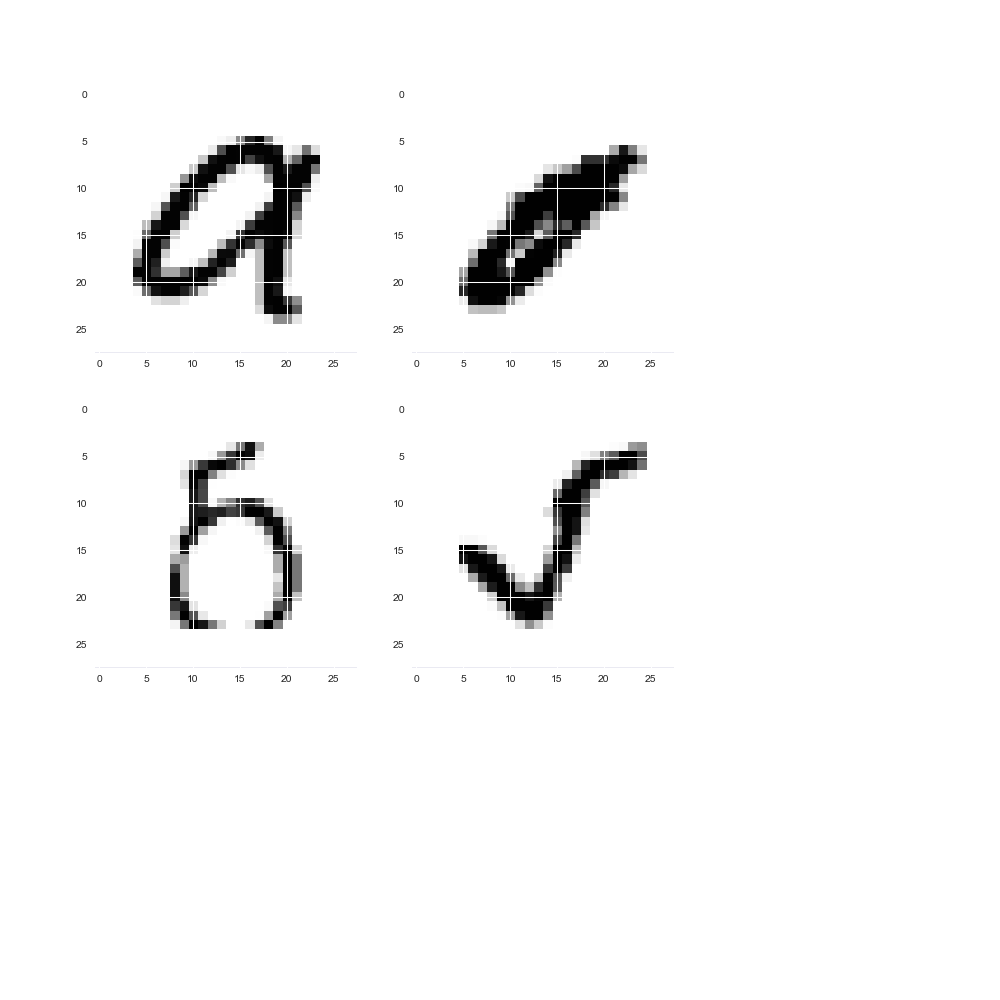

In [43]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

axes[0,0].imshow(np.transpose(np.reshape(TrainInputs[TopTenUncertain[0],:],[28,28])),cmap='Greys')
axes[1,0].imshow(np.transpose(np.reshape(TrainInputs[TopTenUncertain[1],:],[28,28])),cmap='Greys')
axes[0,1].imshow(np.transpose(np.reshape(TrainInputs[TopTenUncertain[2],:],[28,28])),cmap='Greys')
axes[1,1].imshow(np.transpose(np.reshape(TrainInputs[TopTenUncertain[3],:],[28,28])),cmap='Greys')
plt.show()

In [44]:
fig.savefig('MNIST_Uncertain_Samples.png')

<IPython.core.display.Javascript object>


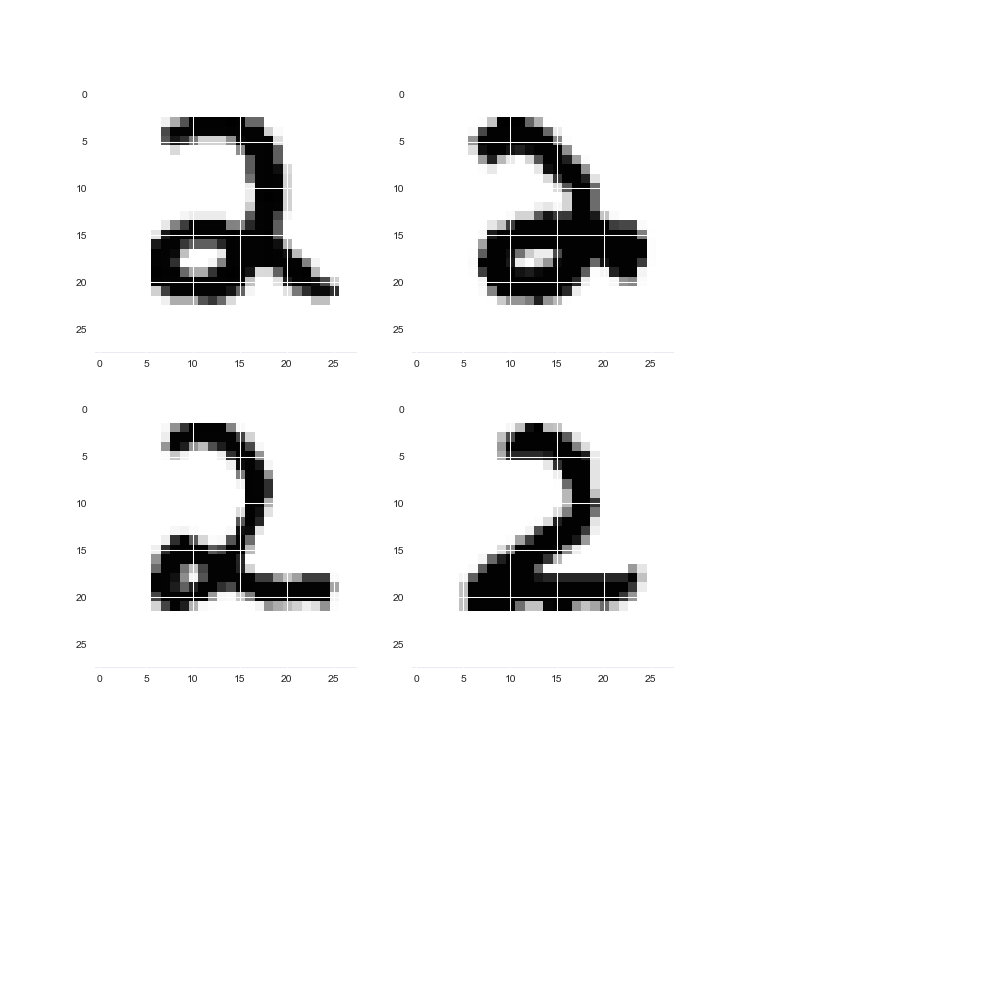

In [38]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

axes[0,0].imshow(np.transpose(np.reshape(TrainInputs[TopTenMostCertain[0],:],[28,28])),cmap='Greys')
axes[1,0].imshow(np.transpose(np.reshape(TrainInputs[TopTenMostCertain[1],:],[28,28])),cmap='Greys')
axes[0,1].imshow(np.transpose(np.reshape(TrainInputs[TopTenMostCertain[2],:],[28,28])),cmap='Greys')
axes[1,1].imshow(np.transpose(np.reshape(TrainInputs[TopTenMostCertain[3],:],[28,28])),cmap='Greys')
plt.show()

In [39]:
fig.savefig('MNIST_certain_Samples.png')